# Topic: Data Mining - Recommendation Systems
## Part 2: NLA Approach - SVD




In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 771 kB 5.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=2626476 sha256=fcd7b294ef234705f7531c8f068453858f7cafecf40cffb1b4d59b99131eb9b6
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [ ]:
import numpy as np #matrix handling
import pandas as pd#dataframe handling
from PIL import Image#Display the Image from the response request
import random
from io import StringIO, BytesIO
import requests #for generating re
from numpy.linalg import svd
import os
import sys
from io import StringIO, BytesIO
import requests
import matplotlib.pyplot as plt
import logging
from IPython.display import display
from collections import defaultdict
from sklearn import metrics
from surprise.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [ ]:
from surprise import SVD, Reader, Dataset #For Matrix Factorization Model Training
from surprise.model_selection import train_test_split, cross_validate 
from surprise.model_selection import LeaveOneOut #required for hit rate calculation
from surprise import KNNBaseline 
import itertools

#**1.Preprocessing**



In [ ]:
!wget http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy

--2022-12-06 20:39:04--  http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy [following]
--2022-12-06 20:39:04--  https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3502475168 (3.3G)
Saving to: ‘AmazonFashion6ImgPartitioned.npy’

AmazonFashion6ImgPa 100%[===================>]   3.26G  10.1MB/s    in 5m 33s  

2022-12-06 20:44:38 (10.0 MB/s) - ‘AmazonFashion6ImgPartitioned.npy’ saved [3502475168/3502475168]



In [ ]:
dataset = np.load("AmazonFashion6ImgPartitioned.npy", encoding="bytes",allow_pickle=True)
[interaction_data, _, _, items, user_num, item_num] = dataset

In [ ]:
 #convert json format to dataframes for easier processing and handling
dataset= []
for i in range(user_num):
  for j in interaction_data[i]:
    dataset.append([j['reviewerID'],j['asin'],j['overall'],j['unixReviewTime'],j['reviewText']])
df_interaction = pd.DataFrame(dataset, columns =['user', 'item','rating','ReviewTime','ReviewText'])
df_interaction.head()

,user,item,rating,ReviewTime,ReviewText
0,A1JWX45KHE34AL,B00APT3MHO,5.0,1384646400,Good for someone who likes skinny jeans but do...
1,A1JWX45KHE34AL,B00CJ5NH36,5.0,1384646400,This shirt with it's bold graphic is seriously...
2,A1JWX45KHE34AL,B00F9NGAPM,3.0,1384646400,The shirt is a little flowy-er than I expected...
3,A2YHF6O2D37PMX,B000LYFF46,3.0,1393804800,"I selected &#34;fit as expected&#34;, but they..."
4,A2YHF6O2D37PMX,B005FPAC8K,1.0,1336348800,May 27: I've worn them 3-4 times each since M...


In [ ]:
#repeat for the metadata
items_interact = []
for i in range(len(items)):
  item_i = items[i][b'asin'].decode("utf-8") #get the item id
  if b'title' in items[i]:
    title_i = items[i][b'title'].decode("utf-8") #get the title
  else:
    title_i = "NA"
  if b'imUrl' in items[i]: #get the image URL
    img_i = items[i][b'imUrl']
  else:
    img_i = "NA"
  #price = items[i][b'price'].decode("utf-8")
  items_interact.append([item_i,title_i, img_i])
items_df = pd.DataFrame(items_interact, columns =['item', 'title','img'])
items_df.head()

,item,title,img
0,B008986OXM,"Cheap Monday Women's Tight Fit Jean, Hard Coat...",b'http://ecx.images-amazon.com/images/I/31bmhq...
1,B00APT3MHO,Cheap Monday Women's Skinny Tight Jean,b'http://ecx.images-amazon.com/images/I/31hFOd...
2,B00CJ5NH36,ELLAZHU Women Crew Neck Crane &amp; Fox Short ...,b'http://ecx.images-amazon.com/images/I/41-ZK3...
3,B00CP11HK4,ELLAZHU Women Geometrical Designs 3/4 Sleeve C...,b'http://ecx.images-amazon.com/images/I/51l0gD...
4,B00F9NGAPM,ELLAZHU Women Baggy Diagonal Stripes Long Slee...,b'http://ecx.images-amazon.com/images/I/41bWE1...


* Retain only active users and items (Users and Items with atleast 5 interactions)

In [ ]:
user_count = df_interaction[["user","item"]].groupby("user").count()
usercount = user_count[user_count["item"] >= 10] #users with item interactions >=5
item_count = df_interaction[["user","item"]].groupby("item").count() #items with user interactions >=5
itemcount = item_count[item_count["user"] >= 10]

In [ ]:
df_updated = df_interaction[df_interaction["user"].isin(usercount.index)\
                            & df_interaction["item"].isin(itemcount.index)]

##2. SVD Implementation to get n most similar items to an input item

In [ ]:
reviewmatrix = df_updated.pivot(index="user", columns="item", values="rating").fillna(0) #create the pivot table for the interaction data
#imputated with 0 
matrix = reviewmatrix.values
u, s, vh = svd(matrix, full_matrices=False) #run svd

In [ ]:
reviewmatrix.head()

item,B00006XXGO,B00009ZM7Z,B0000A4ZJD,B0000A51FU,B0000A522N,B0000ANAKR,B0000ANC7S,B0000ANDU4,B0000AT7N2,B0000ATP8L,...,B00JLSQ9WA,B00JUCOV54,B00JX3UGGI,B00JX59WZW,B00JX5A5L2,B00JXZ54OA,B00K0BPFY0,B00K551QR6,B00KAHVAGG,B00KIHOX3K
user,,,,,,,,,,,,,,,,,,,,,
A00146182PNM90WNNAZ5Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00354001GE099Q1FL0TU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00404823GU1Q517KP4Z8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00475741WVLQL5CVWK2Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02155413BVL8D0G7X6DN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
column = list(reviewmatrix.columns) #list of column names (items)
rows = list(reviewmatrix.T.columns) #list of row names (users)

In [ ]:
def cosine_similarity(v,u):
  '''function to compute cosin similarity'''
  return (v @ u)/ (np.linalg.norm(v) * np.linalg.norm(u))





## Now let's visually verify the working of the recommender before we move on to metric based **comparison**

#### Example 1

In [ ]:
item = column[0]
similarities = {}
for i in range(1,len(column)):
  #print(cosine_similarity(vh[:,0],vh[:,i]))
  similarities[column[i]]=cosine_similarity(vh[:,0],vh[:,i]) #get the similarity of the input item wrt all the other items

In [ ]:
top_n = dict(sorted(similarities.items(), key=lambda item: item[1])[:10])

In [ ]:
top_n

{'B005FI1VE6': -1.1657341758564144e-15,
 'B003YBHF82': -4.579669976578771e-16,
 'B003XDVUEQ': -4.0939474033052677e-16,
 'B0008172S4': -3.3306690738754706e-16,
 'B007WAU1VY': -2.960414031971671e-16,
 'B00AIIQJ5E': -2.688821387764052e-16,
 'B00CN47GXA': -2.636779683484746e-16,
 'B002ATSG8C': -2.5847379792054426e-16,
 'B00AW80P28': -2.2898349882893864e-16,
 'B006W1TYE4': -2.0816681711721695e-16}

* Very low similarity scores because of the sparsity despite the processing step

In [ ]:
def disp_img(link, title):
  '''Function to display the images of the output'''
  response = requests.get(link)
  #print(response)
  print(title)
  img = Image.open(BytesIO(response.content))
  display(img)

["Merrell Men's Jungle Moc Slip-On Shoe"]


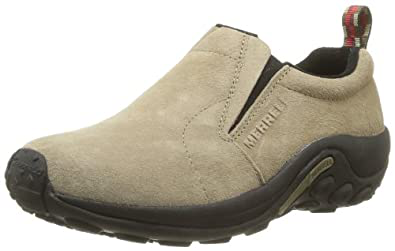

In [ ]:
#get the image output and the title of the input item
item_0_link = list(items_df[items_df['item']==column[1]]['img'])[0]
item_0_title = list(items_df[items_df['item']==column[1]]['title'])
disp_img(item_0_link,item_0_title)

913    Timberland Mad River 2-Strap Sandal (Toddler/L...
Name: title, dtype: object


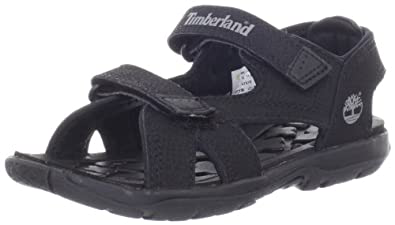

4986    Crocs Women's Sexi Flip Sandal
Name: title, dtype: object


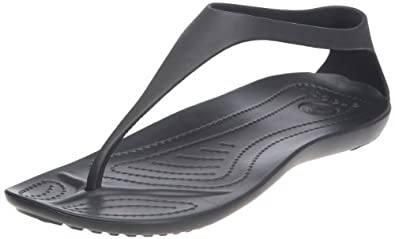

4428    Crocs Women's Kadee Ballet Flat
Name: title, dtype: object


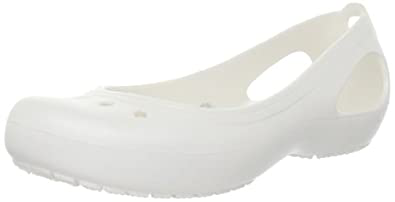

4401    Isotoner Women's Microterry PillowStep Satin C...
Name: title, dtype: object


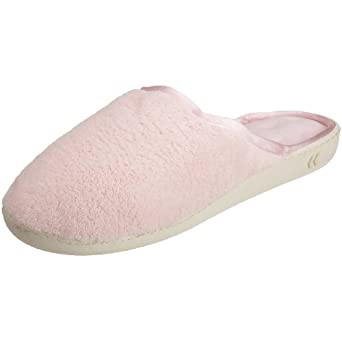

2584    Allegra K Lady Boat Neck Batwing Sleeve Button...
Name: title, dtype: object


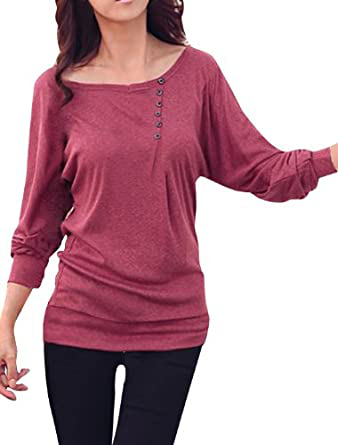

8636    Allegra K Women Tie-Bow Neck All Over Dots 3/4...
Name: title, dtype: object


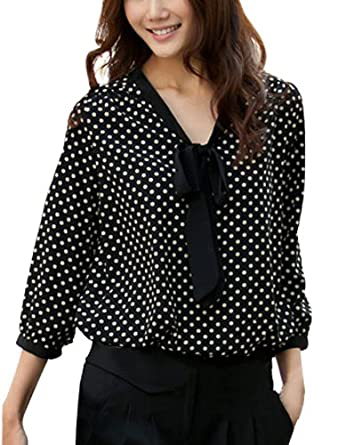

1109    Ladies Scoop Neck Stretchy Long Sleeve Knitted...
Name: title, dtype: object


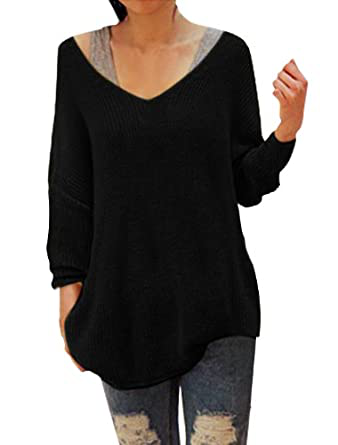

10003    Dockers Men's Signature Khaki D3 Pant
Name: title, dtype: object


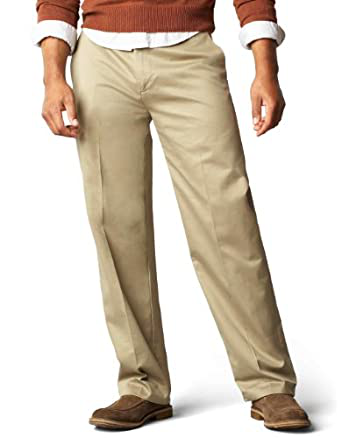

952    Allegra K Women's Mesh Patchwork Front Bracele...
Name: title, dtype: object


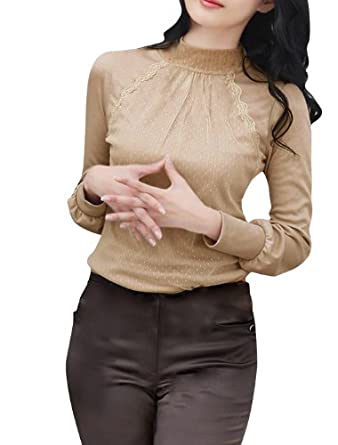

2106    Ever Pretty Sexy V-neck Floral Printed Beach C...
Name: title, dtype: object


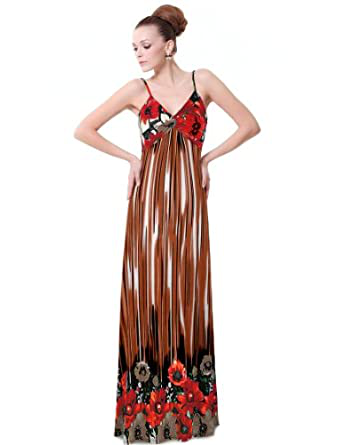

In [ ]:
#get the image and the title of the remaining items
for i,_ in top_n.items():
  disp_img(list(items_df[items_df['item']==i]['img'])[0],items_df[items_df['item']==i]['title'])

#### Example 2

In [ ]:
similarities = {}
for i in range(0,len(column)):
  if i!=8003:
    similarities[column[i]]=cosine_similarity(vh[:,8003],vh[:,i])#get the similarity of the input item wrt all the other items
top_n = dict(sorted(similarities.items(), key=lambda item: item[1])[:10])#get top n

11621    eVogues Plus Size Maxi Dress Black Stripe Print
Name: title, dtype: object


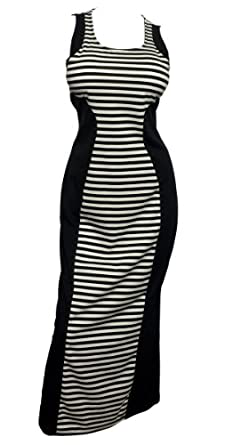

In [ ]:
#display the input item
item_1_link = list(items_df[items_df['item']==column[8003]]['img'])[0]
item_1_title = items_df[items_df['item']==column[8003]]['title']
disp_img(item_1_link,item_1_title)

3813    Clarks Women's June Slippers, Cinnamon, 10 W/D
Name: title, dtype: object


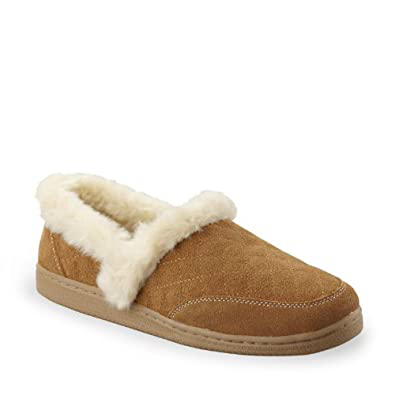

9470    Teva Women's Mush II Natural Flip Flop
Name: title, dtype: object


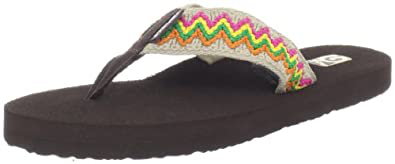

13144    Jackson  Boys 2-7 Straight Fit Jean, Black, 4R
Name: title, dtype: object


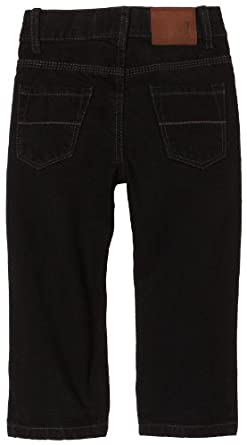

61995    Miusol Luxury Romantic Stand-up Collar Waist B...
Name: title, dtype: object


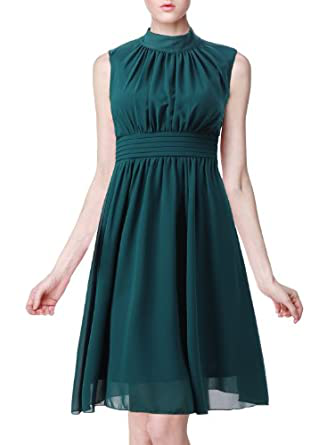

28898    Clarks Women's Loyal Heart Pump
Name: title, dtype: object


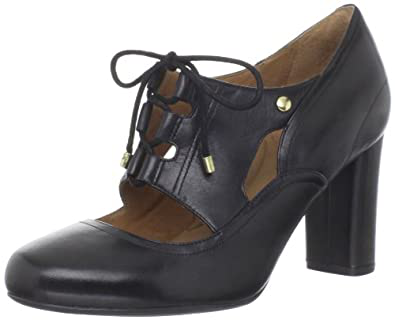

77128    Zumba Fitness Women's Z-kickz II Dance Sneaker...
Name: title, dtype: object


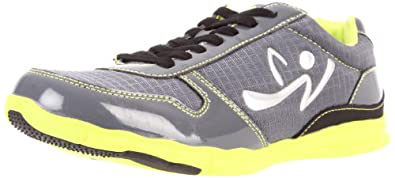

45658    Skechers Women's Sport Fashion Sneaker
Name: title, dtype: object


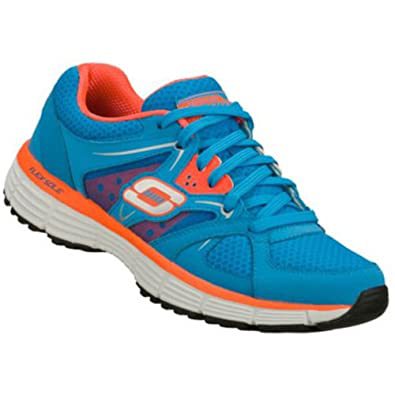

80260    Saucony Originals Women's Jazz Sneaker
Name: title, dtype: object


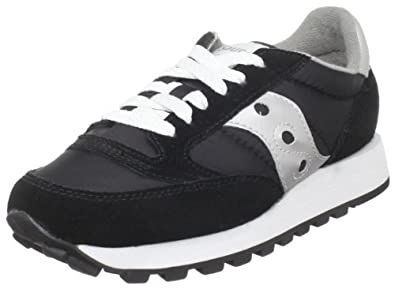

109990    Rampage Women's Cairo Wedge Sandal
Name: title, dtype: object


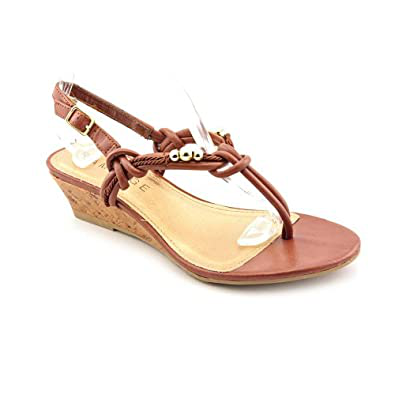

7362    Indian Tunic Top Womens Kurti Printed Blouse I...
Name: title, dtype: object


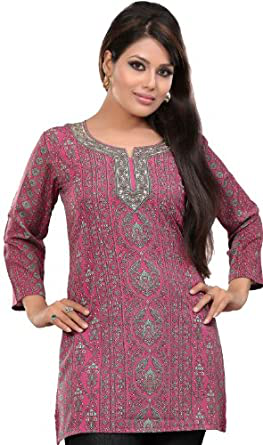

In [ ]:
#get the image and the title of the remaining items
for i,_ in top_n.items():
  disp_img(list(items_df[items_df['item']==i]['img'])[0],items_df[items_df['item']==i]['title'])


## 3. Rating Prediction Using SVD
* We make use of Surprise Module for this problem

In [ ]:
df = Dataset.load_from_df(df_interaction[['user', 'item', 'rating']], reader=Reader(rating_scale=(1, 5)))
model = SVD()#initialize the model
trainset, testset = train_test_split(df, test_size=.2) #train test split

In [ ]:
model.fit(trainset) 
predictions = model.test(testset)
sse = 0
for p in predictions:
  sse += (p.r_ui - p.est)**2
mse = sse / len(predictions)

In [ ]:
print('The Model MSE is:',mse)

The Model MSE is: 1.2245567942581228


In [ ]:
sse = 0
for p in predictions:
  sse += abs(p.r_ui - p.est)
mae = sse / len(predictions)

In [ ]:
print('The Model MAE is:',mae)

The Model MAE is: 0.8760828332946046


In [ ]:
def get_binary_pr(predictions, threshold):
  df_pred = pd.DataFrame(predictions)
  df_pred['r_ui'].where(df_pred['r_ui']>threshold, 1, inplace=True)
  df_pred['r_ui'].where(df_pred['r_ui']<=threshold, 0, inplace=True)

  df_pred['est'].where(df_pred['est']>threshold, 1, inplace=True)
  df_pred['est'].where(df_pred['est']<=threshold, 0, inplace=True)

  return df_pred['r_ui'], df_pred['est']

In [ ]:
true_r, pred = get_binary_pr(predictions,3.5)
AUC = roc_auc_score(true_r, pred)
print('The Model AUC is:',AUC)

The Model AUC is: 0.5262152600228773


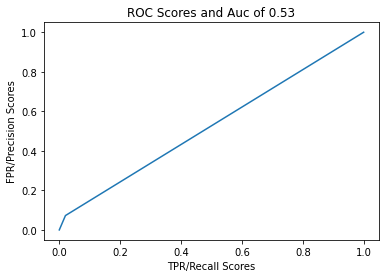

In [ ]:
def roc (true_r, pred):
    fp, tp, thresholds = roc_curve(true_r, pred)
    auc_ = auc(fp, tp)
    plt.plot(fp, tp, '-')
    plt.ylabel("FPR/Precision Scores")
    plt.xlabel("TPR/Recall Scores")
    plt.title("ROC Scores and Auc of " + str(round(auc_, 2)))
    plt.show()
roc(true_r, pred)

## *3.1* Top 5 recommendations based on user habits and ratings data


In [ ]:
df = Dataset.load_from_df(df_updated[['user', 'item', 'rating']], reader=Reader(rating_scale=(1, 5)))
model = SVD()
trainset = df.build_full_trainset()
model.fit(trainset)

In [ ]:
reviewmatrix = df_updated.pivot(index="user", columns="item", values="rating").fillna(0) #imputated with 0

In [ ]:
def get_rec(user,n):
  '''
  Overview: Function to get top n recommendations based on the rating predictions.
  Working: The function takes a user as input and iterates through all the items in the 
           matrix which the user has not rated.
  Return: Top n predictions are returned.
  '''
  rated = []
  for i in reviewmatrix.columns:
    #print(i)
    if reviewmatrix.loc[user][i] != 0.0:
      rated.append(i)  
    if reviewmatrix.loc[user][i]==0:
      pred = model.predict(uid=user, iid=i)
      #print(pred)
      reviewmatrix.loc[user][i] = pred.est
  recommendations = pd.DataFrame(reviewmatrix.loc[user].sort_values(axis=0,ascending=False))
  recommendations.drop(index=rated, axis=0, inplace=True)
  #print(recommendations.columns)
  top_rec = recommendations.head(n)
  for index,i in top_rec.iterrows():
    #print(index)
    disp_img(list(items_df[items_df['item']==index]['img'])[0],items_df[items_df['item']==index]['title'])
    print('Predicted Rating:', i)

      
  return recommendations.head(n)


In [ ]:
#define the input user
input = 'A00404823GU1Q517KP4Z8'
df_user = df_updated[df_updated['user']=='A00404823GU1Q517KP4Z8']

In [ ]:
df_user

,user,item,rating,ReviewTime,ReviewText
103995,A00404823GU1Q517KP4Z8,B004Q85B7O,3.0,1354752000,I have special issues so for me it's just ok. ...
103996,A00404823GU1Q517KP4Z8,B005FHXPFK,4.0,1362355200,This Jambu is one of the best shoes I've worn ...
103998,A00404823GU1Q517KP4Z8,B0074BNKLO,4.0,1391731200,This shoe its and looks great. Great for a li...
104001,A00404823GU1Q517KP4Z8,B008IB4LCQ,4.0,1384905600,"Very comfortable, and good for those really ho..."


35638    Softwalk Women's Sandee Slip-On Loafer
Name: title, dtype: object


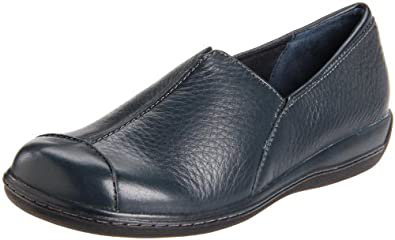

3.0
12617    Jambu Women's Quest Flat,Sand,7.5 M US
Name: title, dtype: object


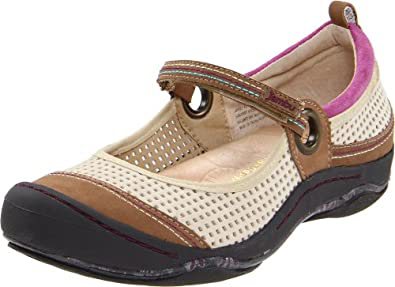

4.0
25255    Clarks Women's Chateau Manor II Ballet Flat
Name: title, dtype: object


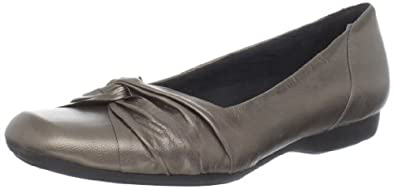

4.0
84462    Easy Spirit Women's Cloverly Sandal
Name: title, dtype: object


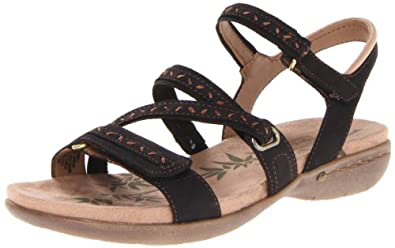

4.0


In [ ]:
#iterate through all the items which the user has already bought/rated
for index,i in df_user.iterrows():
  #print(index)
  disp_img(list(items_df[items_df['item']==i['item']]['img'])[0],items_df[items_df['item']==i['item']]['title'])
  print(i['rating'])

283    Merrell Women's Hollyleaf Sandal
Name: title, dtype: object


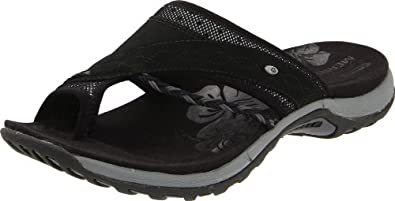

Predicted Rating: A00404823GU1Q517KP4Z8    4.79727
Name: B0058YYKSG, dtype: float64
95    Skechers Women's Go Walk Slip-On
Name: title, dtype: object


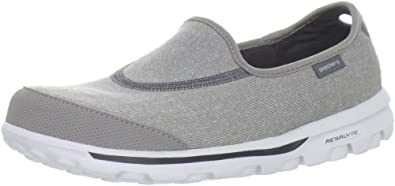

Predicted Rating: A00404823GU1Q517KP4Z8    4.754479
Name: B0058XIMMM, dtype: float64
2590    UGG Kids and Toddlers Classic Short Boot
Name: title, dtype: object


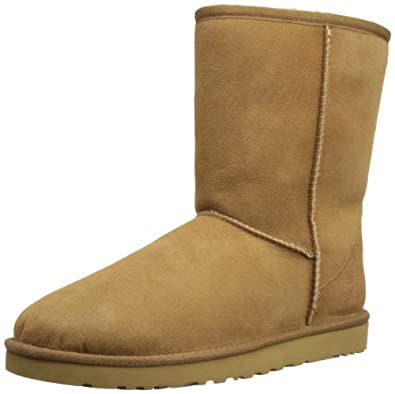

Predicted Rating: A00404823GU1Q517KP4Z8    4.689879
Name: B000E69Z3S, dtype: float64
41371    Columbia Women's BL4277 Sun Light Backstrap Sa...
Name: title, dtype: object


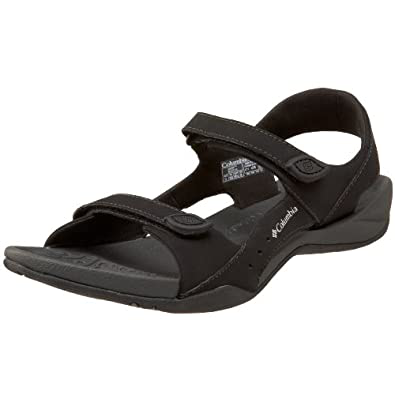

Predicted Rating: A00404823GU1Q517KP4Z8    4.68941
Name: B001OD2Y0Q, dtype: float64
4806    Lindy Bop Vintage 50's Audrey Hepburn Style Sw...
Name: title, dtype: object


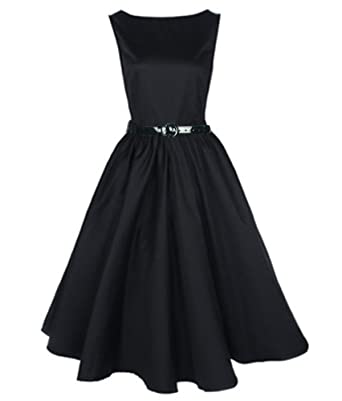

Predicted Rating: A00404823GU1Q517KP4Z8    4.68767
Name: B0064X6JGQ, dtype: float64


,A00404823GU1Q517KP4Z8
item,
B0058YYKSG,4.797270
B0058XIMMM,4.754479
B000E69Z3S,4.689879
B001OD2Y0Q,4.689410
B0064X6JGQ,4.687670


In [ ]:
#view the top n recommended items for the user
get_rec('A00404823GU1Q517KP4Z8',5)

## 3.2 Examining Model on Beyond Metrics

* We explore Diversity and Hit Rate as two additional Metrics to determine the rating diversity

In [ ]:
#get users and items with atleast 10 interaction to not overwhelm the hardware
user_count = df_interaction[["user","item"]].groupby("user").count()
usercount = user_count[user_count["item"] >= 10]
item_count = df_interaction[["user","item"]].groupby("item").count()
itemcount = item_count[item_count["user"] >= 10]
df_updated = df_interaction[df_interaction["user"].isin(usercount.index) & df_interaction["item"].isin(itemcount.index)]

In [ ]:
#training
df = Dataset.load_from_df(df_updated[['user', 'item', 'rating']], reader=Reader(rating_scale=(1, 5)))
model = SVD()

In [ ]:
#reference: https://towardsdatascience.com/evaluating-a-real-life-recommender-system-error-based-and-ranking-based-84708e3285b
# reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Movielens%20Recommender%20Metrics.ipynb
def GetTopN(predictions, n, minimumRating=3.0):
  '''The function fetches the top N recommendations for a user given a minimum rating threshold'''
  topN = defaultdict(list)
  for user, item, actualRating, estimatedRating, _ in predictions:
    if (estimatedRating >= minimumRating):
      topN[user].append((item, estimatedRating))

  for user, ratings in topN.items():
    ratings.sort(key=lambda x: x[1], reverse=True)
    topN[user] = ratings[:n]
  return topN

In [ ]:
#reference: https://towardsdatascience.com/evaluating-a-real-life-recommender-system-error-based-and-ranking-based-84708e3285b
# reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Movielens%20Recommender%20Metrics.ipynb
'''
Leave one example from the training set.
We use that example for measuring our hit rate.
'''
LOO = LeaveOneOut(n_splits=1, random_state=1)
from collections import defaultdict
for trainSet, testSet in LOO.split(df):
    # Train model without left-out ratings
    model.fit(trainSet)
    # Predicts ratings for left-out ratings only
    leftOutPredictions = model.test(testSet)
    # Build predictions for all ratings not in the training set
    TestSet = trainSet.build_anti_testset()
    Predictions = model.test(TestSet)
    # Compute top 5 recs for each user
    topNPredicted = GetTopN(Predictions, n=3)

In [ ]:
#reference: https://towardsdatascience.com/evaluating-a-real-life-recommender-system-error-based-and-ranking-based-84708e3285b
# reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Movielens%20Recommender%20Metrics.ipynb
def HitRate(topNPredicted, leftOutPredictions):
  '''Function to measure the hit rate.
  Working: Given N recommendation, check if the left out example 
  made it to the list
  '''
  hits = 0
  n = 0
 # For each left-out rating
  for i in leftOutPredictions:
    user = i[0]
    leftoutitem = i[1]
    # Is it in the predicted top 10 for this user?
    hit = False
    for item, predictedRating in topNPredicted[user]:
      if (leftoutitem) == item:
        hit = True
        break
    if (hit) :
        hits += 1
    n += 1
  return hits/n
print("\nHit Rate: ", HitRate(topNPredicted, leftOutPredictions))


Hit Rate:  0.0026035502958579883


In [ ]:
#reference: https://towardsdatascience.com/evaluating-a-real-life-recommender-system-error-based-and-ranking-based-84708e3285b
# reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Movielens%20Recommender%20Metrics.ipynb
def Diversity(topN,simslgo):
    '''Function to determine the diversity of the recommendation
    Working: Each recommended is compared against each other to determine their similarity.
    return 1-total similarity
    '''
    n = 0#measure total items
    similarity = 0 #measures the totalsimilarity between items
    simMat = simsAlgo.compute_similarities()
    for userId in topN.keys():
        pairs = itertools.combinations(topN[userId],2) #get combinations of two items for comparison
        for pair in pairs:
            item1 = pair[0][0]
            item2 = pair[1][0]
            id1 = simsAlgo.trainset.to_inner_iid(str(item1)) #get the index of the item
            id2 = simsAlgo.trainset.to_inner_iid(str(item2))
            similarity += simMat[id1][id2] #measure similarity between the item
            n += 1
    return 1 - (similarity / n)

In [ ]:
sim_options = {'name': 'cosine', 'user_based': False}
simsAlgo = KNNBaseline(sim_options=sim_options) #using simple collaborative model to fetch user-item similarity
trainfull = df.build_full_trainset()
simsAlgo.fit(trainfull)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
Diversity(topNPredicted,simsAlgo)

Computing the cosine similarity matrix...
Done computing similarity matrix.


0.8796100277325039

## 4. Results Plot

In [ ]:
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly import tools



trace2 = go.Bar(
    x=['MSE'],
    y=[1.2245],
    text=[1.2245],
    textposition='auto',
)
trace3 = go.Bar(
    x=['MAE'],
    y=[0.8760828],
    text = [0.8760828],
    textposition='auto',
)
# trace4 = go.Bar(
#     x=['Hit Rate'],
#     y=[0.0022970],
#     text = [0.0022970],
#     textposition='auto',
# )
# trace5 = go.Bar(
#     x=['Diversity'],
#     y=[0.9021],
#     text = [0.9021],
#     textposition='auto',
# )




fig = tools.make_subplots(rows=1, cols=2,
                          shared_xaxes=True, shared_yaxes=True,
                          vertical_spacing=1)
fig.update_layout(legend_orientation="h")
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace3, 1, 2)
# fig.append_trace(trace4, 1, 3)
# fig.append_trace(trace5, 1, 4)

fig['layout'].update(height=650, width=800, title='SVD Performance', yaxis_title="Metric Scores")
fig.show()
fig.update_traces(textposition="outside")

pyo.plot(fig, filename='bar-charts-with-shared-axis.html')

/usr/local/lib/python3.8/dist-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



'bar-charts-with-shared-axis.html'